Python感知机可以理解为简单的二分类问题，输入X，输出对应值y（1，或者-1），其变换可以用y=wx+b来描述。根据已知样本（X,Y），不断调整参数w和b，待确定参数w和b之后，基本的模型也就确定了。

In [1]:
import numpy as np
class Perceptron(object):
    def __init__(self, eta=0.01, iter=10):
        '''初始化，eta为变化步长，默认是0.01；iter是学习的轮数，默认是10'''
        self.eta = eta
        self.iter = iter
    def fit(self, X, y):
        '''开始学习，每次变更参数，同时记录每一轮的错误率；
        zip(x,y)每次取出对应的x和y，一一对应的；'''
        self.w = np.zeros(1 + X.shape[1]) # Add b，wx+b，即w[0]是b，w[1:]是对应的w
        self.errors = []

        for _ in range(self.iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi)) #target是目标值，predit计算出来的是预测值，二者差值则是需要变更的量；乘以对应变更步长
                self.w[1:] += update * xi #使用的是梯度上升法；梯度上升法和下降法实际是一个公司，应用是上升法是+，下降法是-
                self.w[0] += update
                errors += int(update != 0.0) #直接加update，则update有正有负，不能体现准确的错误率；这里记录的是错误个数
            self.errors.append(errors)
        return self
    
    def net_input(self, X):
        '''计算wx+b，获取的是一个值，所以使用的是dot'''
        return np.dot(X, self.w[1:]) + self.w[0]

    def predict(self, X):
        '''根据wx+b，和目标0比较，大于0则是1，小于0则为-1；使用了np中的where功能'''
        return np.where(self.net_input(X) >= 0.0, 1, -1)


    通过以上的代码，我们实现了一个感知机。我们可以初始化一个新的Perceptron对象，并且对学习率eta和迭代次数n_iter赋值，fit方法先对权重参数初始化，然后对训练集中每一个样本循环，根据感知机算法对权重进行更新。类别通过predict方法进行预测。除此之外，self.errors还记录了每一轮中误分类的样本数，有助于接下来我们分析感知机的训练过程。

下面我们通过具体数据测试下上述感知机，使用Eirs数据集。

In [4]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')
print df.tail()

     5.1  3.5  1.4  0.2     Iris-setosa
144  6.7  3.0  5.2  2.3  Iris-virginica
145  6.3  2.5  5.0  1.9  Iris-virginica
146  6.5  3.0  5.2  2.0  Iris-virginica
147  6.2  3.4  5.4  2.3  Iris-virginica
148  5.9  3.0  5.1  1.8  Iris-virginica


接下来我们抽取出上述的前100条样本，这正好是Setosa和Versicolor对应的样本，我们将Versicolor对应的数据作为类别1，Setosa对应的作为-1。

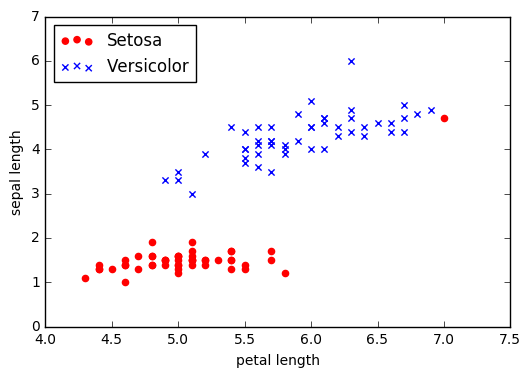

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
y=df.iloc[0:100, 4].values
y=np.where(y=='Iris-setosa', -1, 1)
X = df.iloc[0:100, [0,2]].values #前两个特征作为x的维度
plt.scatter(X[:50,0], X[:50, 1], color='red', marker='o', label='Setosa')
plt.scatter(X[50:100,0], X[50:100, 1], color='blue', marker='x', label='Versicolor')
plt.xlabel('petal length')
plt.ylabel('sepal length')
plt.legend(loc='upper left')
plt.show()

下面开始训练感知机模型，同时将每一轮的误分类数目可视化出来，检查算法是否收敛和找到分界线。

In [11]:
ppn=Perceptron(eta=0.1, iter=10)
ppn.fit(X,y)

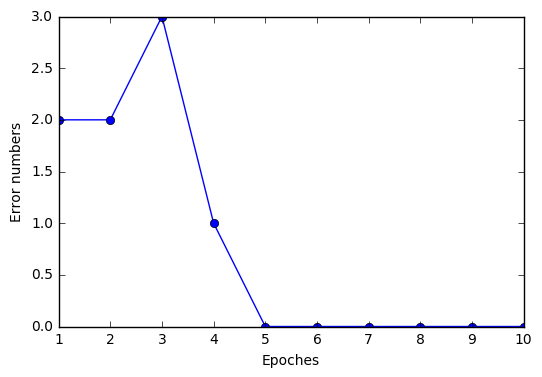

In [13]:
plt.plot(range(1, len(ppn.errors) + 1), ppn.errors, marker = 'o')
plt.xlabel('Epoches')
plt.ylabel('Error numbers')
plt.show()

通过上图可以知道，第5次迭代时，感知机算法已经收敛了，准群率100%。接下来我们将分界线画出来。

In [27]:
from matplotlib.colors import ListedColormap
def plot_decision_region(X, y, classifier, resolution=0.02):
    #定义分隔符及颜色
    markers=('s', 'x', 'o', '^', 'v')
    colors=('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap=ListedColormap(colors[:len(np.unique(y))]) #根据分类器的个数灵活取对应的区分标记和颜色
    
    #获取两个类别的边界
    x1_min, x1_max = X[:, 0].min() -1, X[:,0].max() + 1
    x2_min, x2_max = X[:, 1].min() -1, X[:,1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    Z=classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    for idx, c1 in enumerate(np.unique(y)):
        plt.scatter(x=X[y == c1, 0], y=X[y == c1, 1],alpha=0.8, c=cmap(idx), marker=markers[idx], label=c1)

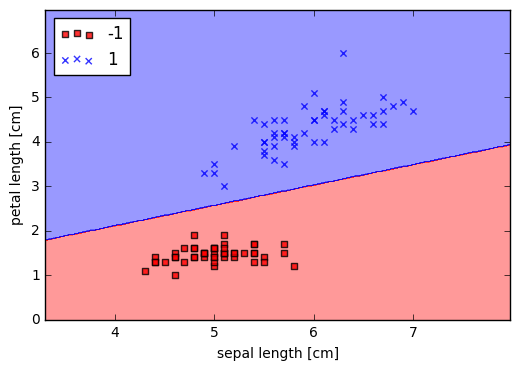

In [28]:
plot_decision_region(X, y, classifier=ppn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

虽然对于Iris数据集，感知机算法表现的很完美，但是"收敛"一直是感知机算法中的一大问题。Frank Rosenblatt从数学上证明了只要两个类别能够被一个现行超平面分开，则感知机算法一定能够收敛。